## Imports

In [1]:
import copy
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from sklearn.model_selection import train_test_split
import torchvision
from torchvision import transforms
from config import config
import os
import sys
current_dir = os.getcwd()
# path = "C:\\Users\\eirik\\Documents\\Master\\ISLBBNN\\islbbnn"
path = "/Users/eirikhoyheim/local_files/master/ISLBBNN/islbbnn"
# path = "C:\\you\\path\\to\\islbbnn\\folder\\here"
os.chdir(path)
import plot_functions as pf
import pipeline_functions as pip_func
sys.path.append('networks')
from lrt_net import BayesianNetwork
import torch.nn.functional as F

os.chdir(current_dir) # set the working directory back to this one 

# Problem description

The MNIST dataset from Lecun et al.

# Batch size and parameters

In [2]:
# define parameters
HIDDEN_LAYERS = config['n_layers'] - 2 
epochs = config['num_epochs']
post_train_epochs = config['post_train_epochs']
dim = config['hidden_dim']
num_transforms = config['num_transforms']
n_nets = config['n_nets']
lr = config['lr']
class_problem = config["class_problem"]
verbose = config['verbose']
save_res = config['save_res']
patience = config['patience']
a_prior = config['a_prior']
SAMPLES = 1



#---------DATA------------
trainset = torchvision.datasets.MNIST(root='./mnist', train=True, download=True, transform=transforms.ToTensor())
testset = torchvision.datasets.MNIST(root='./mnist', train=False, download=True, transform=transforms.ToTensor())

train_data = trainset.data/255.
train_target = trainset.targets

test_data = (testset.data/255.)
test_target = testset.targets

p = train_data.shape[-1]

X_original = torch.cat((train_data, test_data), 0).detach().numpy().reshape(-1,p*p)
y_original = torch.cat((train_target, test_target), 0).detach().numpy()

n,p = X_original.shape
print(n,p,dim)

n_classes = len(np.unique(y_original))
multiclass = n_classes > 1

BATCH_SIZE = int((n*0.8)/5)
TEST_BATCH_SIZE = int(n*0.10) # Would normally call this the "validation" part (will be used during training)
VAL_BATCH_SIZE = int(n*0.10) # and this the "test" part (will be used after training)

TRAIN_SIZE = int((n*0.80)/5)
TEST_SIZE = int(n*0.10) # Would normally call this the "validation" part (will be used during training)
VAL_SIZE = int(n*0.10) # and this the "test" part (will be used after training)

NUM_BATCHES = TRAIN_SIZE/BATCH_SIZE

assert (TRAIN_SIZE % BATCH_SIZE) == 0
assert (TEST_SIZE % TEST_BATCH_SIZE) == 0

70000 784 50


# ReLU based network

## Seperate a test set for later

In [3]:
# Split keep some of the data for validation after training
X, X_test, y, y_test = train_test_split(
    copy.deepcopy(X_original), copy.deepcopy(y_original), test_size=0.10, random_state=42, stratify=y_original)

test_dat = torch.tensor(np.column_stack((X_test,y_test)),dtype = torch.float32)

## Train, validate, and test network

In [ ]:
# select the device and initiate model

# DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "mps")
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}

all_nets = {}
metrics_several_runs = []
metrics_median_several_runs = []
for ni in range(n_nets):
    post_train = False
    print('network', ni)
    # Initate network
    torch.manual_seed(ni+42)
    #---------------------------
    # DIFFERENCE IS IN act_func=F.relu part
    net = BayesianNetwork(dim, p, HIDDEN_LAYERS, classification=class_problem, a_prior=a_prior, n_classes=n_classes, act_func=F.relu).to(DEVICE)
    #---------------------------
    alphas = pip_func.get_alphas_numpy(net)
    nr_weights = np.sum([np.prod(a.shape) for a in alphas])
    print(nr_weights)

    optimizer = optim.Adam(net.parameters(), lr=lr)
    
    all_nll = []
    all_loss = []

    # Split into training and test set
    X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=1/9, random_state=ni)#, stratify=y)
            
    train_dat = torch.tensor(np.column_stack((X_train,y_train)),dtype = torch.float32)
    val_dat = torch.tensor(np.column_stack((X_val,y_val)),dtype = torch.float32)
    
    # Train network
    counter = 0
    highest_acc = 0
    best_model = copy.deepcopy(net)
    for epoch in range(epochs + post_train_epochs):
        if verbose:
            print(epoch)
        nll, loss = pip_func.train(net, train_dat, optimizer, BATCH_SIZE, NUM_BATCHES, p, DEVICE, nr_weights, post_train=post_train, multiclass=multiclass)
        nll_val, loss_val, ensemble_val = pip_func.val(net, val_dat, DEVICE, verbose=verbose, reg=(not class_problem), multiclass=multiclass)
        if ensemble_val >= highest_acc:
            counter = 0
            highest_acc = ensemble_val
            best_model = copy.deepcopy(net)
        else:
            counter += 1
        
        all_nll.append(nll)
        all_loss.append(loss)

        if epoch == epochs-1:
            post_train = True   # Post-train --> use median model 
            for name, param in net.named_parameters():
                for i in range(HIDDEN_LAYERS+1):
                    #if f"linears{i}.lambdal" in name:
                    if f"linears.{i}.lambdal" in name:
                        param.requires_grad_(False)

        if counter >= patience:
            break
        
    all_nets[ni] = net 
    # Results
    metrics, metrics_median = pip_func.test_ensemble(all_nets[ni], test_dat, DEVICE, SAMPLES=10, reg=(not class_problem), multiclass=multiclass) # Test same data 10 times to get average 
    metrics_several_runs.append(metrics)
    metrics_median_several_runs.append(metrics_median)

if verbose:
    print(metrics)
m = np.array(metrics_several_runs)
m_median = np.array(metrics_median_several_runs)

After training:

* 311 weights used in median model $\rightarrow$ density of 0.65\% compared to initialized model (47'540 weigths) 
* ACC of 91\% for median model
* ACC of 91\% for full model

## Weights used each class

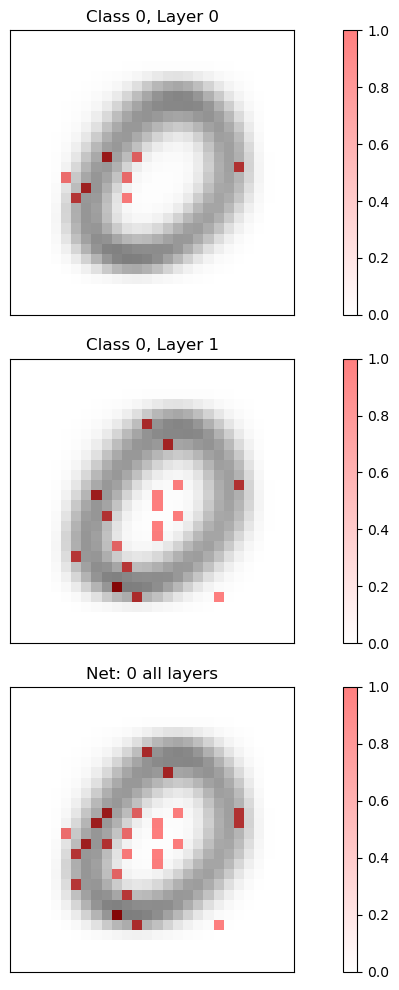

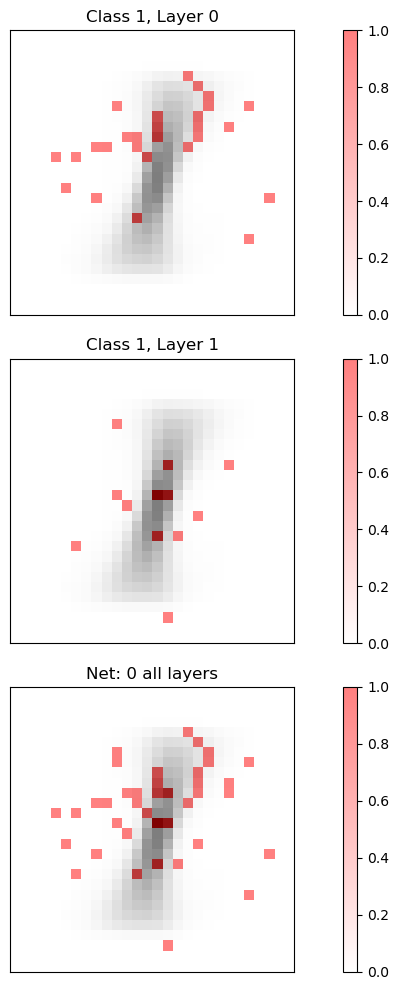

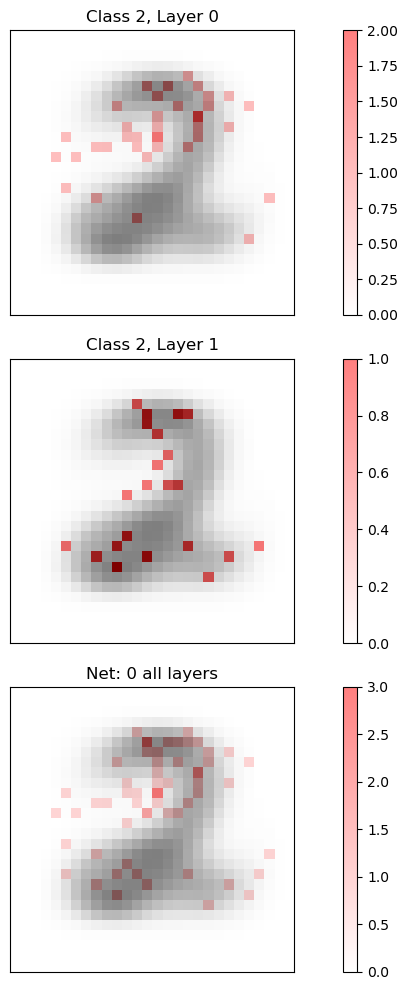

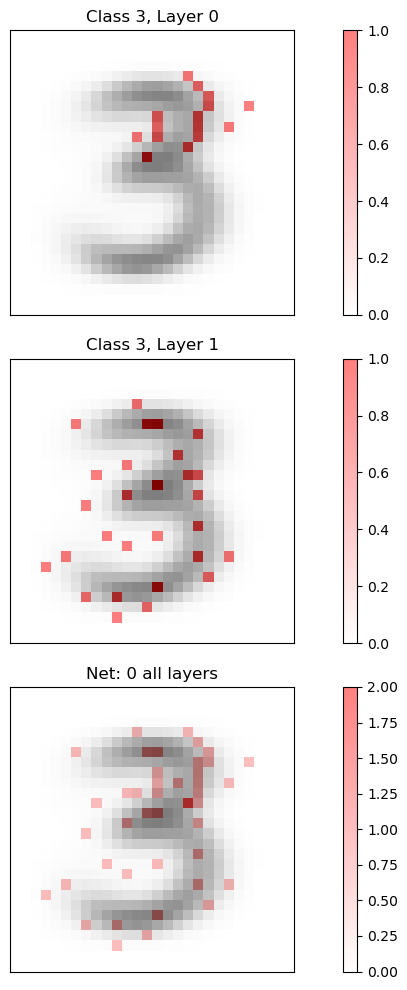

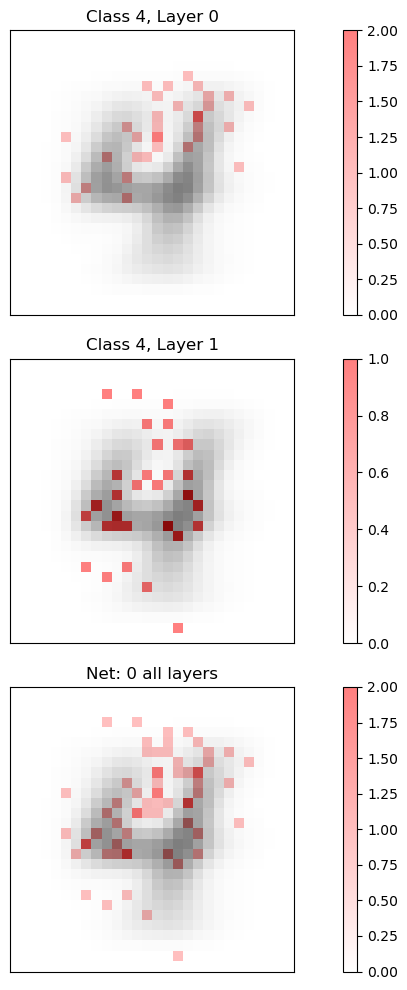

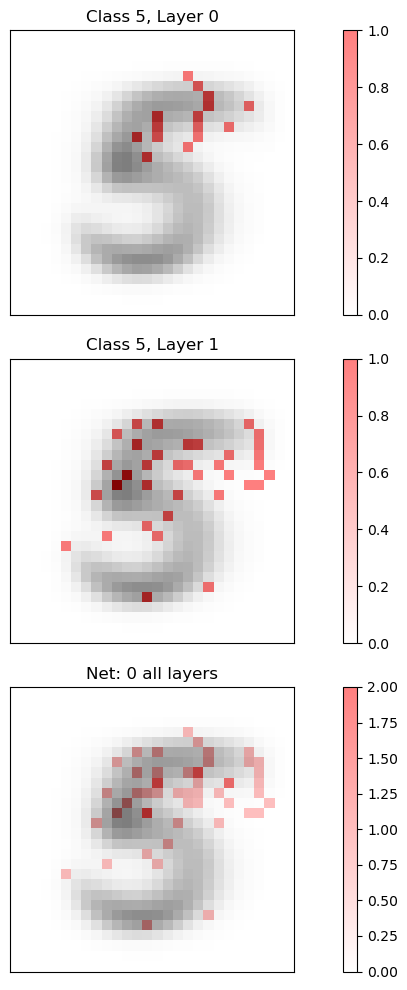

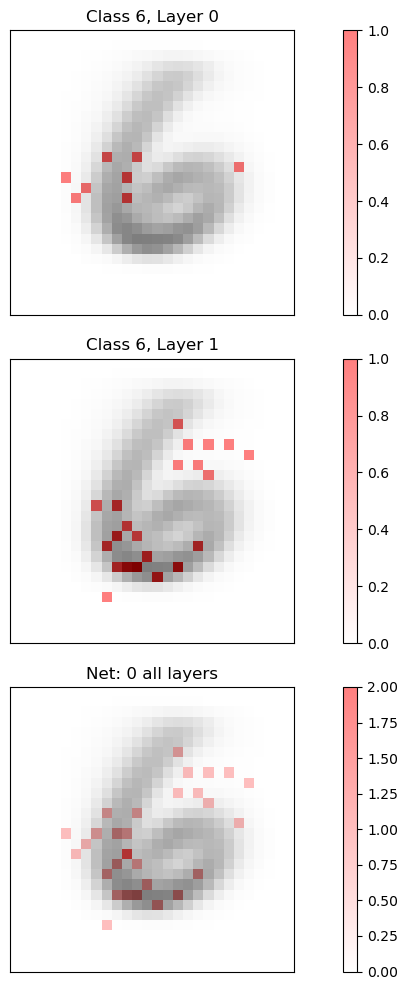

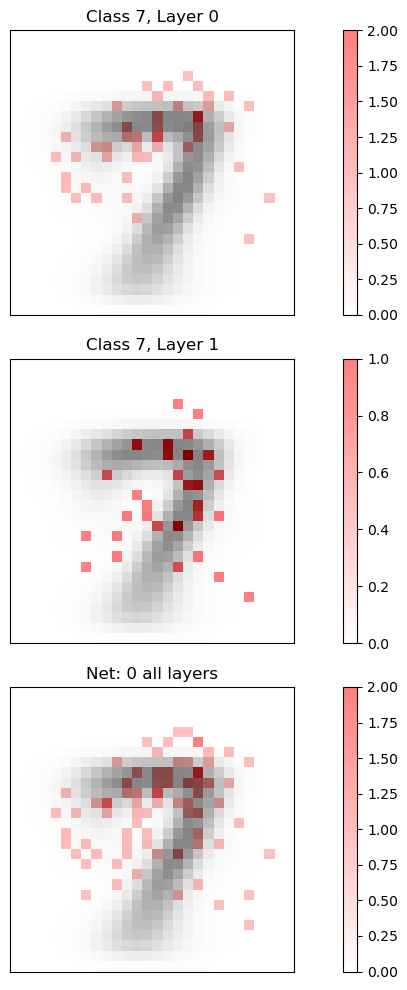

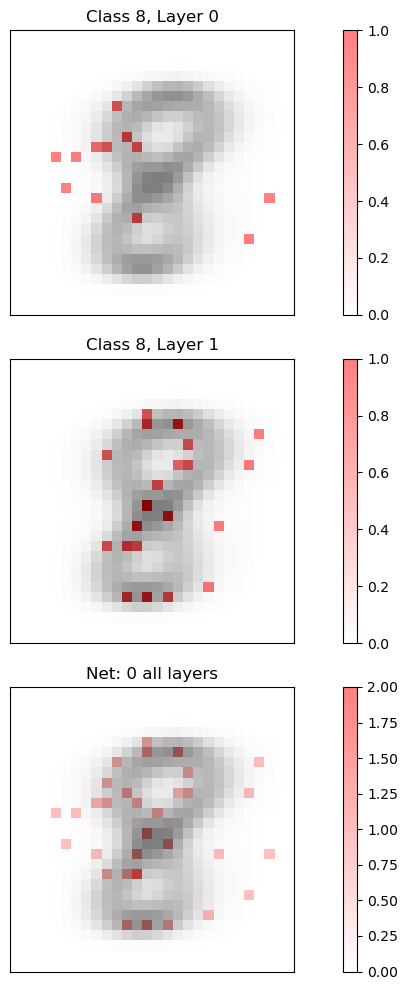

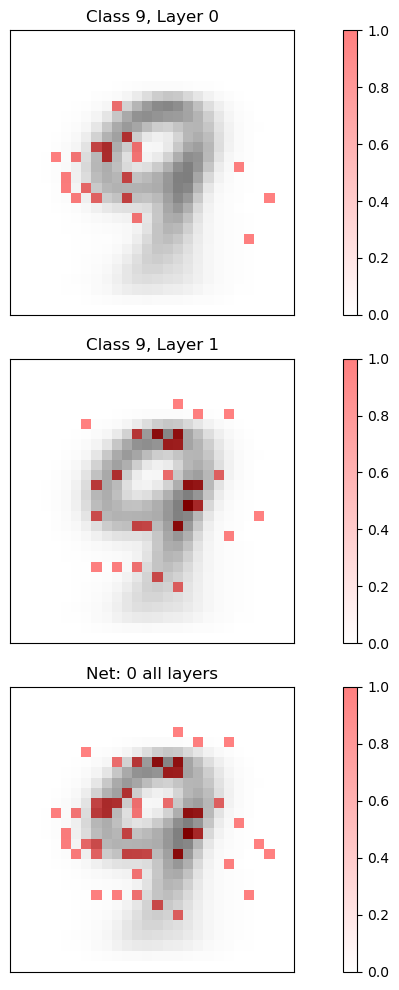

In [5]:
train_data = torch.tensor(copy.deepcopy(X_original),dtype=torch.float32)
train_target = torch.tensor(copy.deepcopy(y_original), dtype=torch.float32)
for c in range(n_classes):
    pf.plot_model_vision_image(net, train_data=train_data, train_target=train_target, c=c, save_path=f"individual_classes/class{c}_lime_shap")

## Local explaination

In [6]:
p = int(p**0.5)  # Just for ease of use

Used 96 and 26 as local explainations in thesis

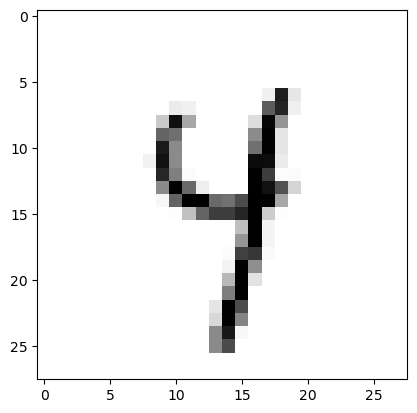

In [40]:
import matplotlib.pyplot as plt
explain_this = train_data[26].reshape(-1,p*p)
plt.imshow(explain_this.reshape((p,p)), cmap="Greys")
plt.show()

In [41]:
from importlib import reload

In [42]:
current_dir = os.getcwd()
# path = "C:\\Users\\eirik\\Documents\\Master\\ISLBBNN\\islbbnn"
path = "/Users/eirikhoyheim/local_files/master/ISLBBNN/islbbnn"
# path = "C:\\you\\path\\to\\islbbnn\\folder\\here"
os.chdir(path)
reload(pf)
reload(pip_func)

os.chdir(current_dir) # set the working directory back to this one 


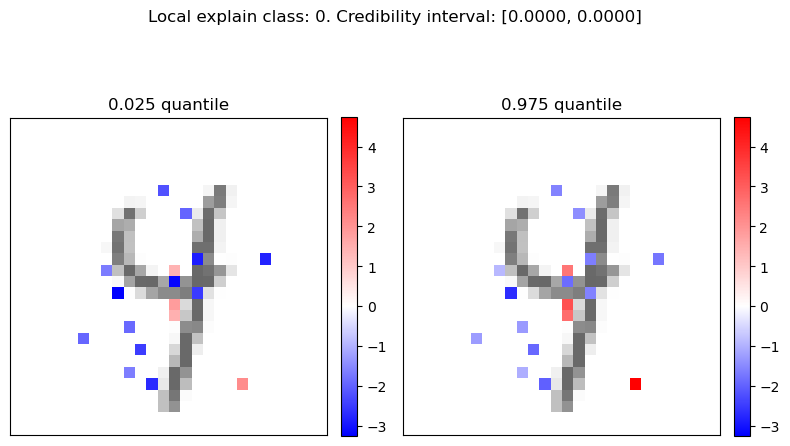

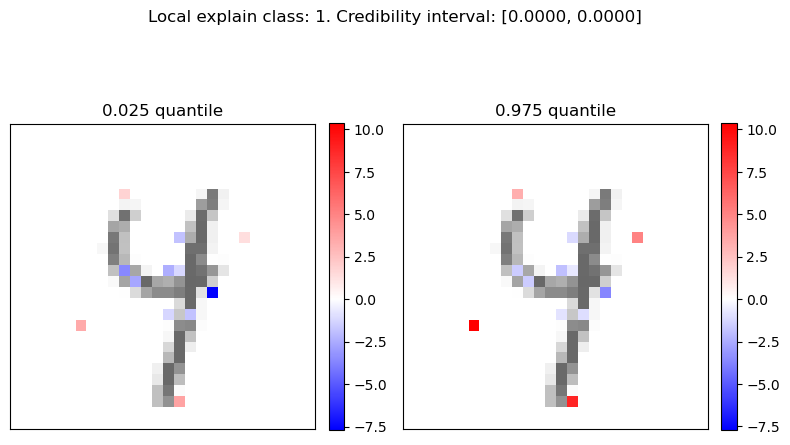

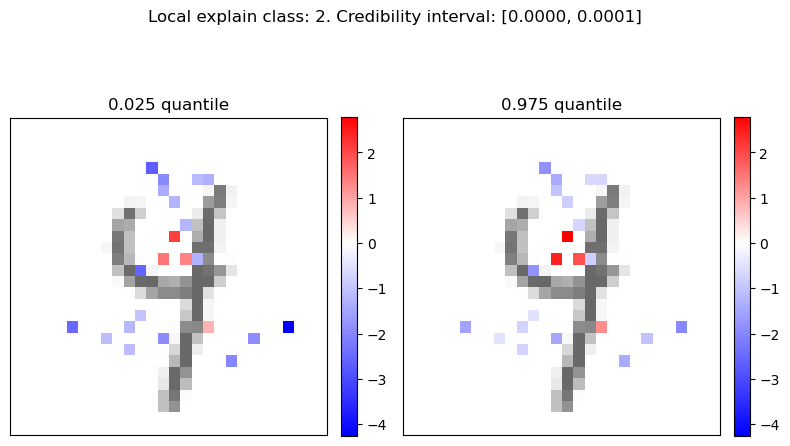

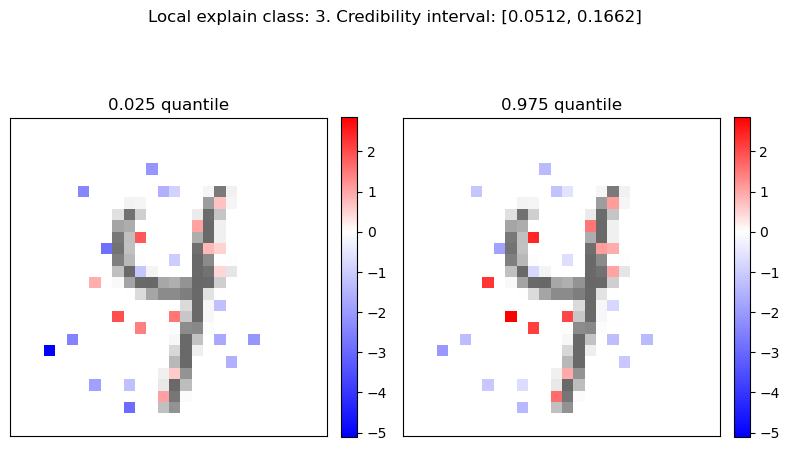

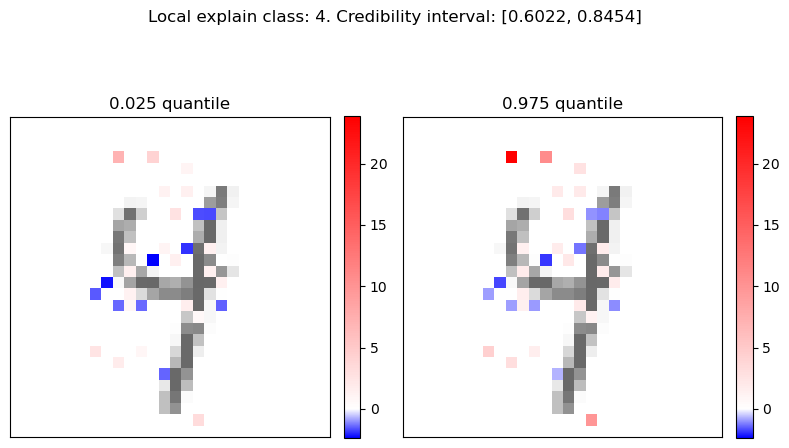

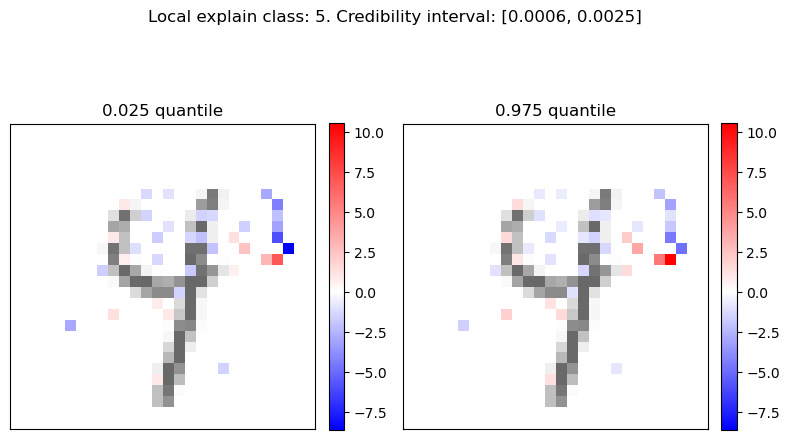

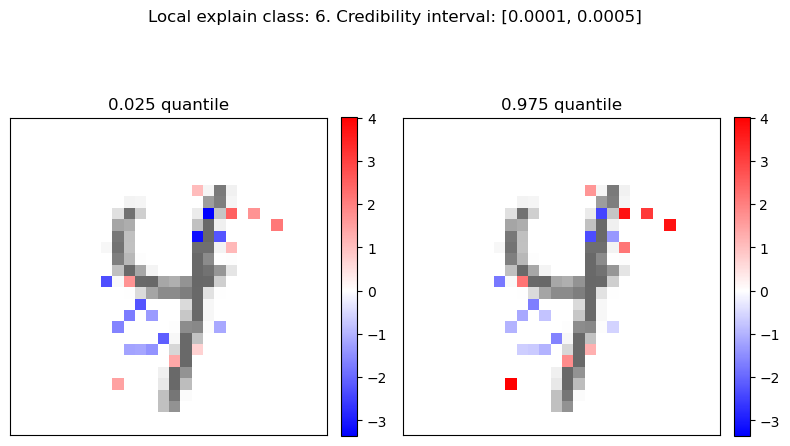

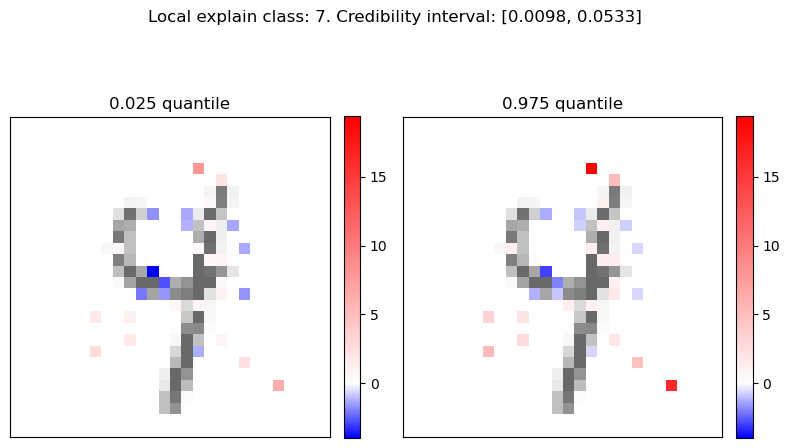

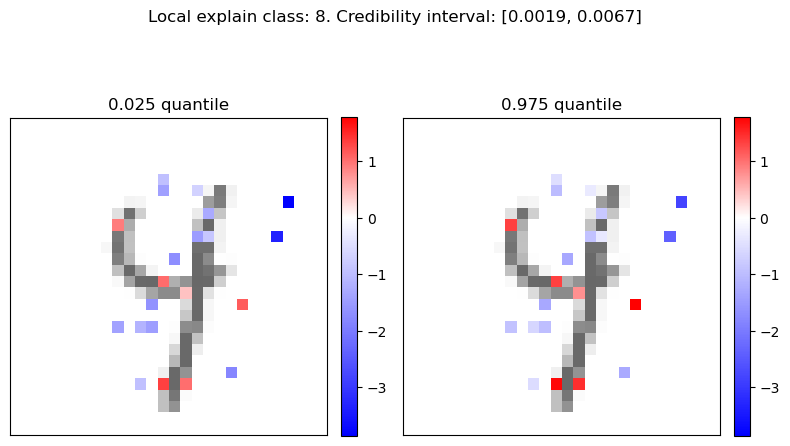

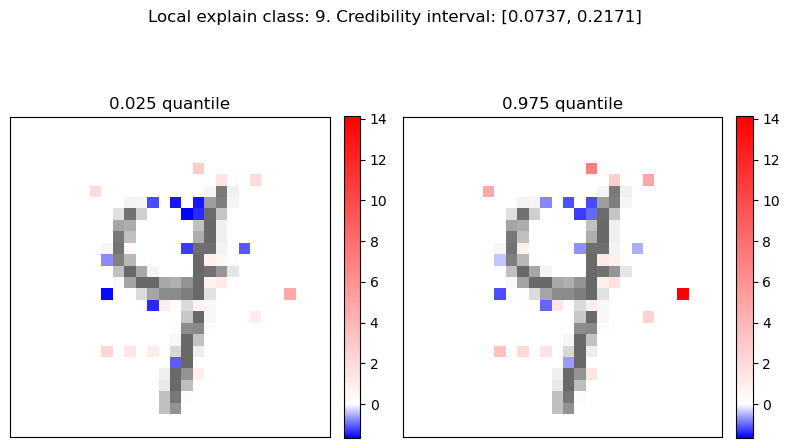

In [43]:
pf.plot_local_contribution_images_contribution_empirical_magnitude(net, explain_this, n_classes=n_classes, n_samples=100, save_path="../examples/mnist/local_plots/digit4_lime_shap")

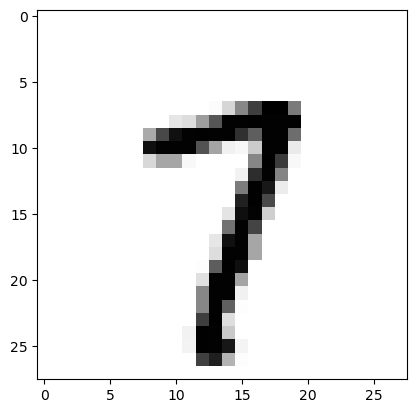

In [35]:
import matplotlib.pyplot as plt
explain_this = train_data[96].reshape(-1,p*p)
plt.imshow(explain_this.reshape((p,p)), cmap="Greys")
plt.show()

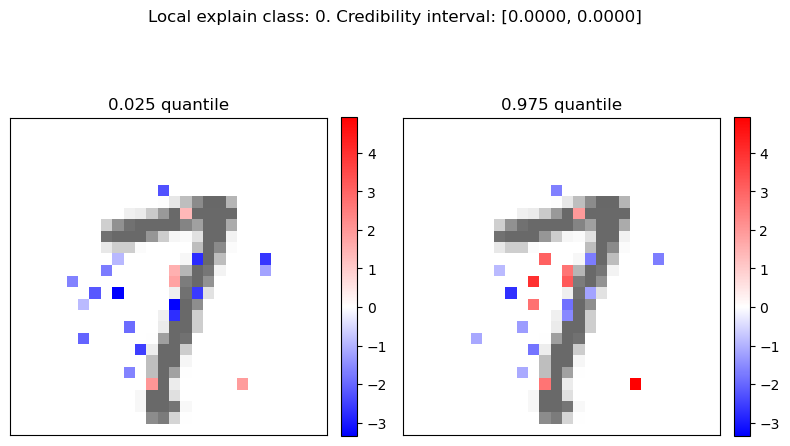

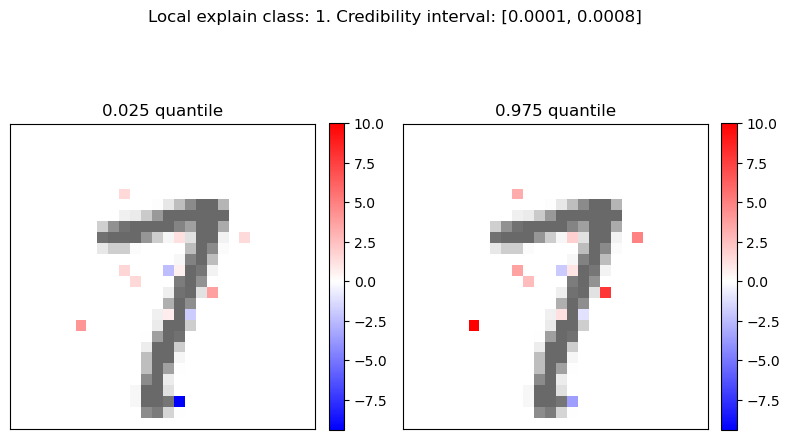

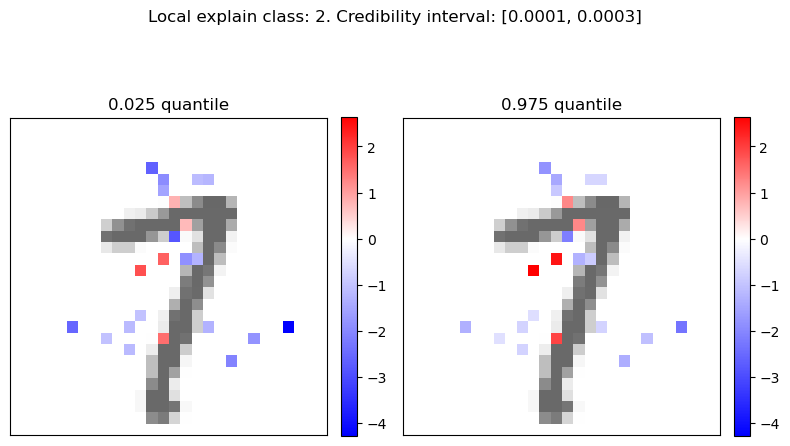

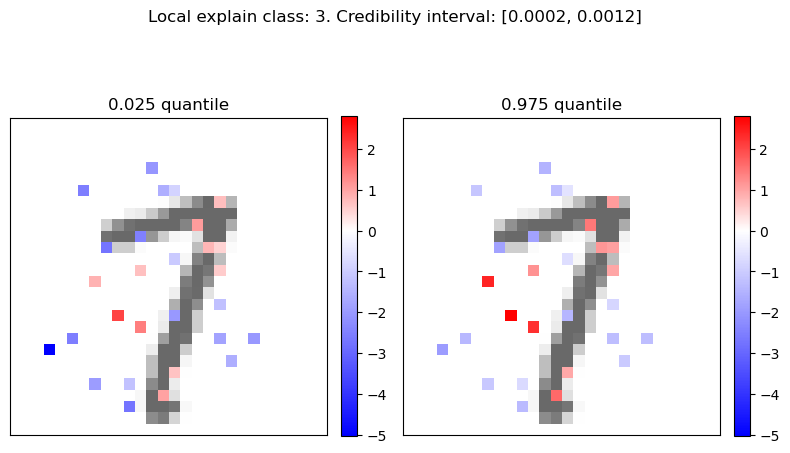

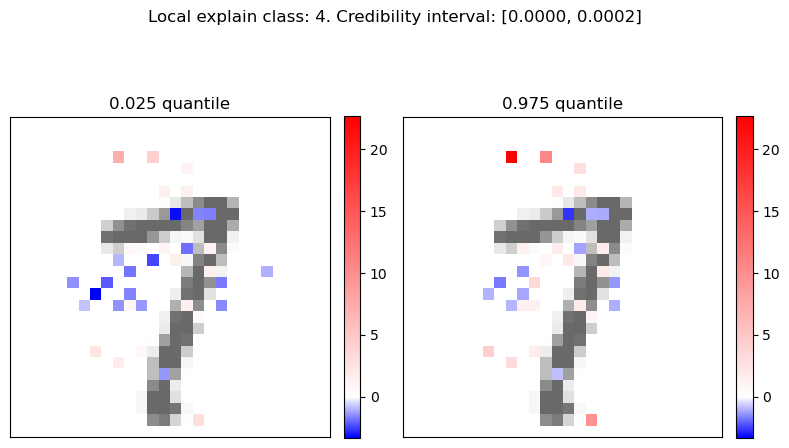

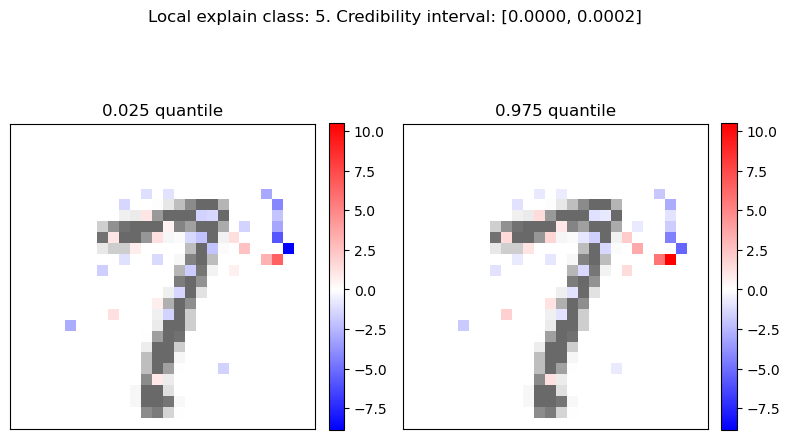

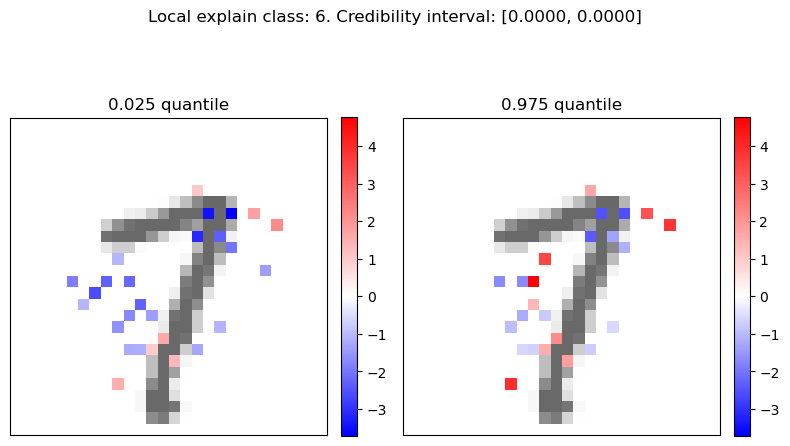

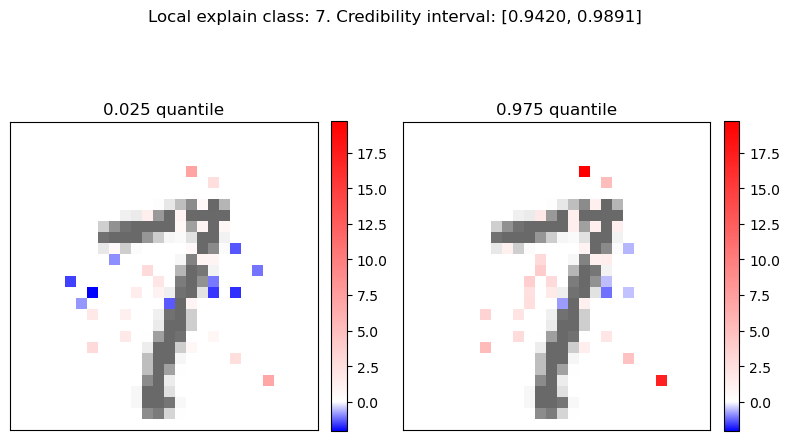

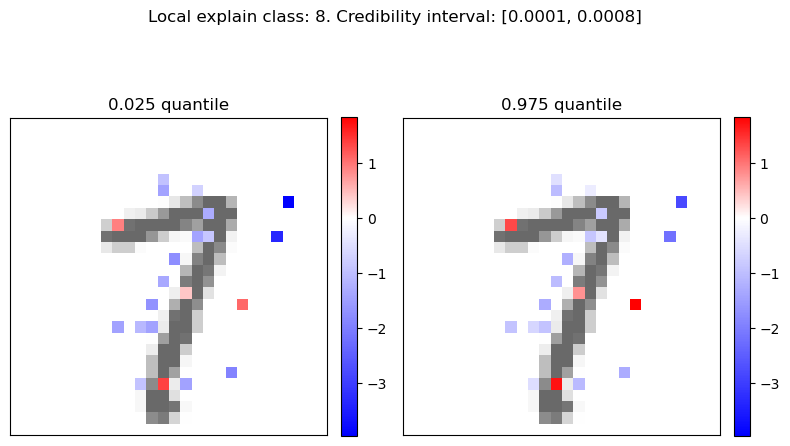

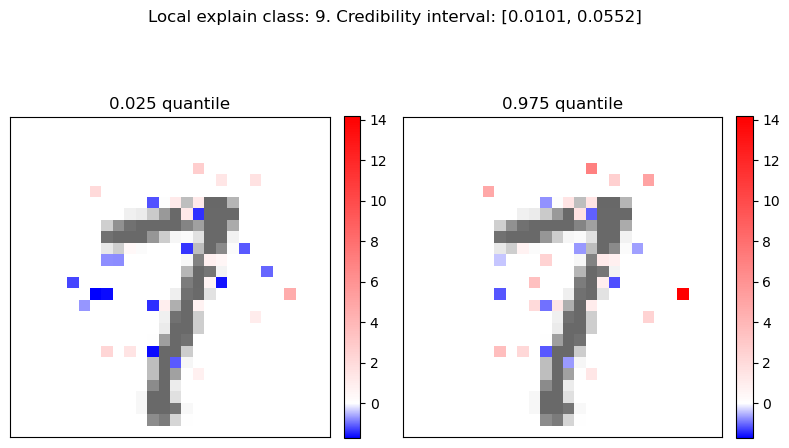

In [39]:
pf.plot_local_contribution_images_contribution_empirical_magnitude(net, explain_this, n_classes=n_classes, n_samples=100, save_path="../examples/mnist/local_plots/digit7_lime_shap")

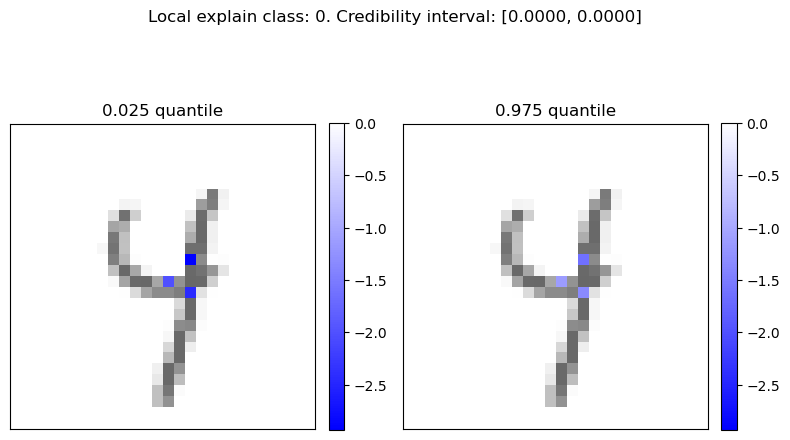

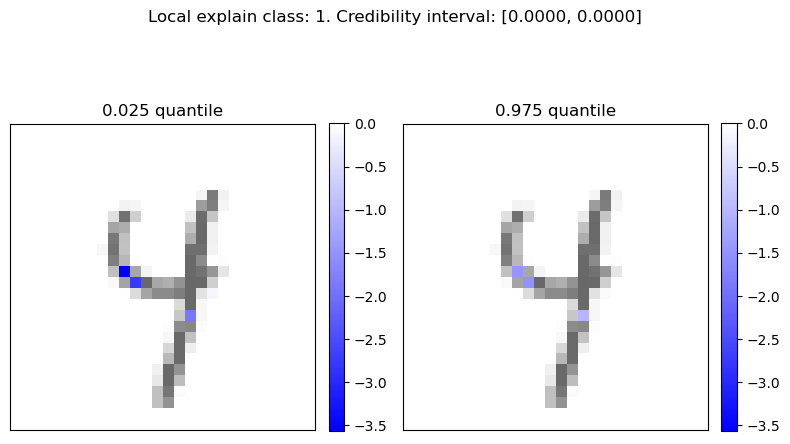

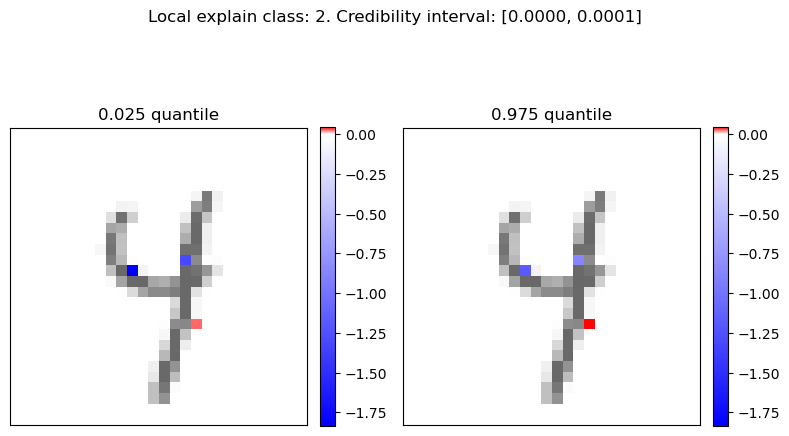

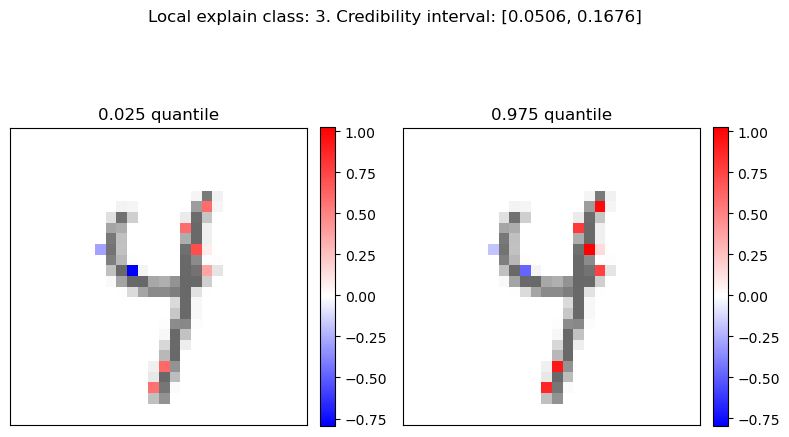

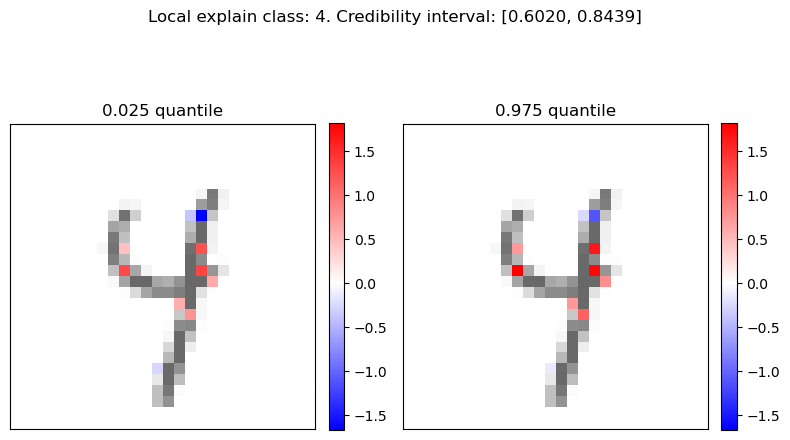

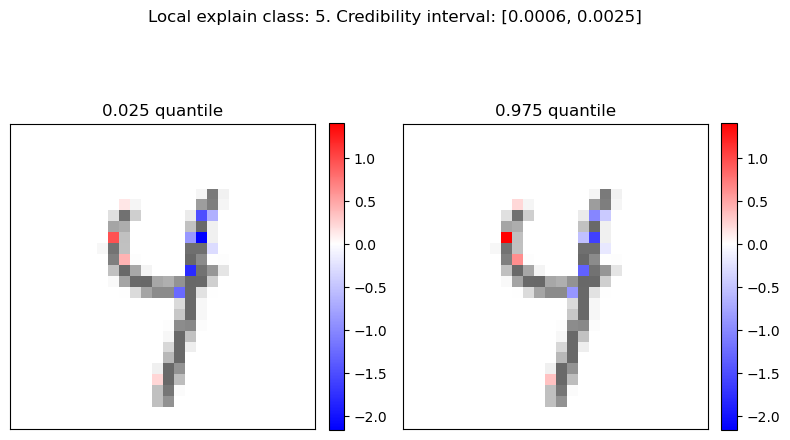

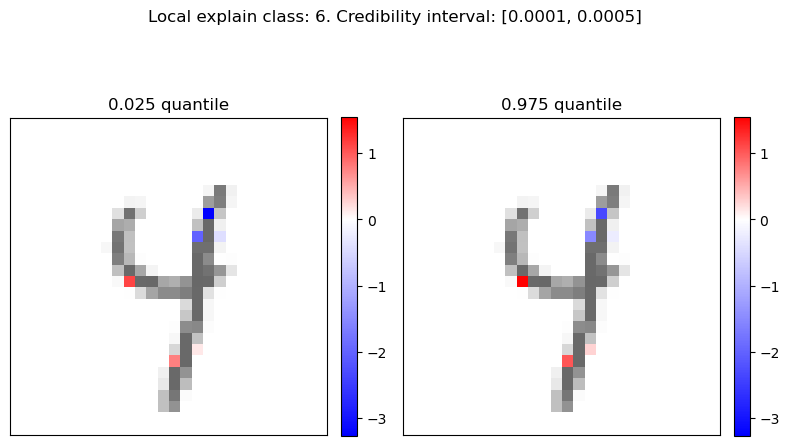

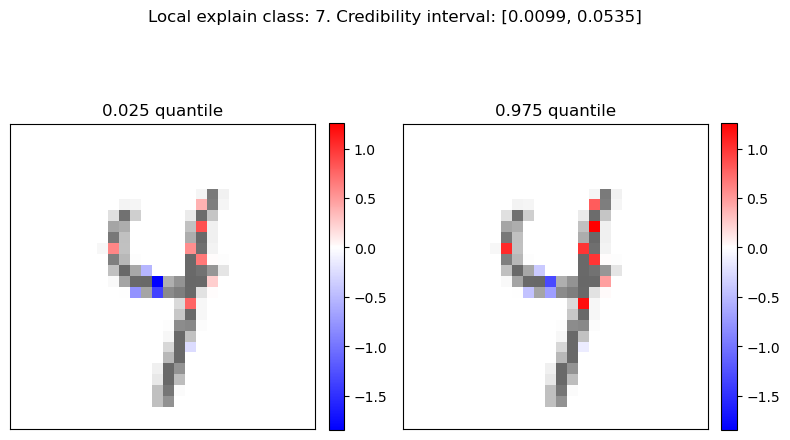

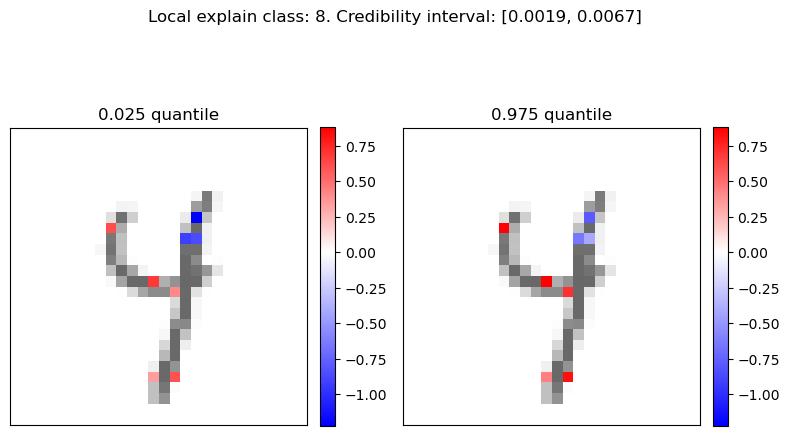

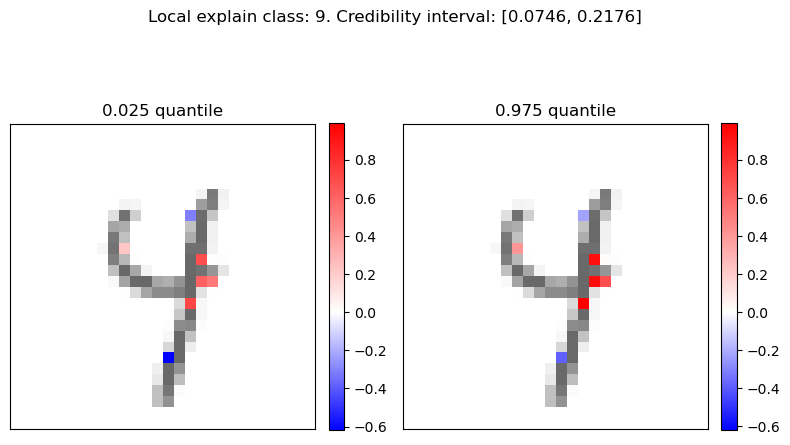

In [13]:
pf.plot_local_contribution_images_contribution_empirical(net, explain_this, n_classes=n_classes, n_samples=100, save_path="local_plots/digit4")

In [ ]:
# pf.plot_local_contribution_images_contribution_dist(net, explain_this, n_classes=n_classes)

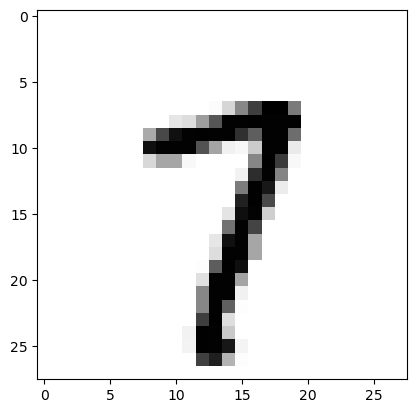

In [14]:
import matplotlib.pyplot as plt
explain_this = train_data[96].reshape(-1,p*p)
plt.imshow(explain_this.reshape((p,p)), cmap="Greys")
plt.show()

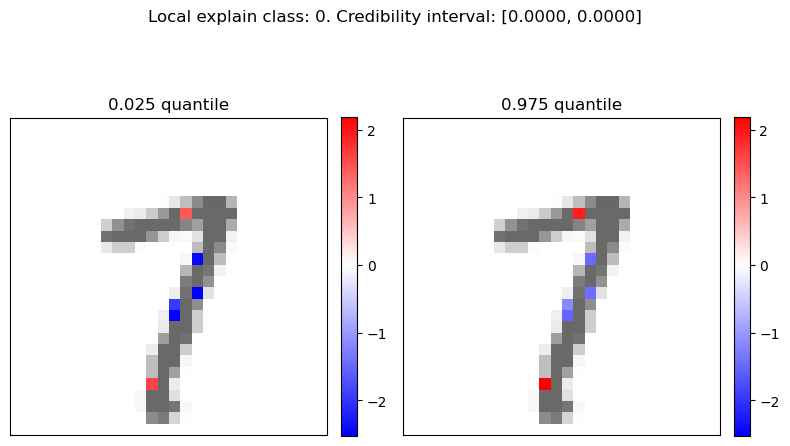

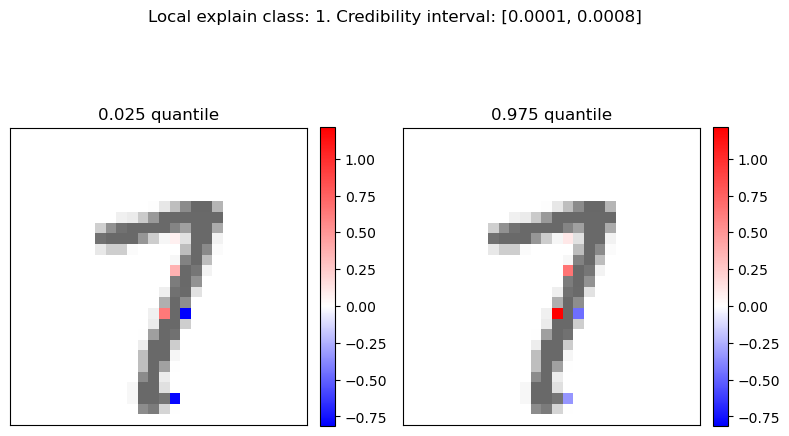

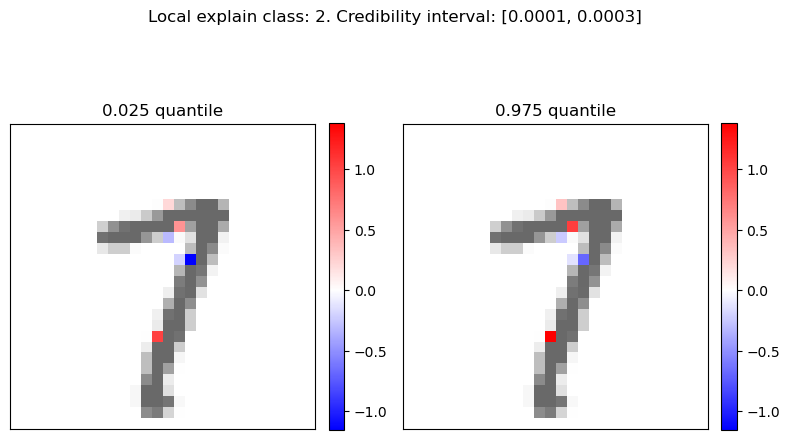

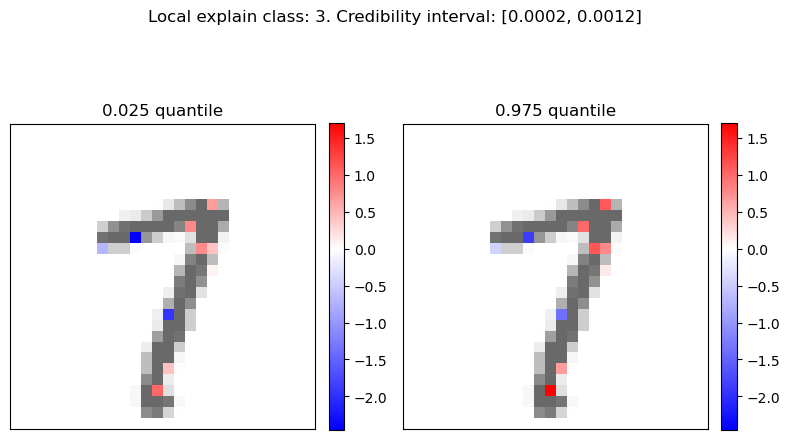

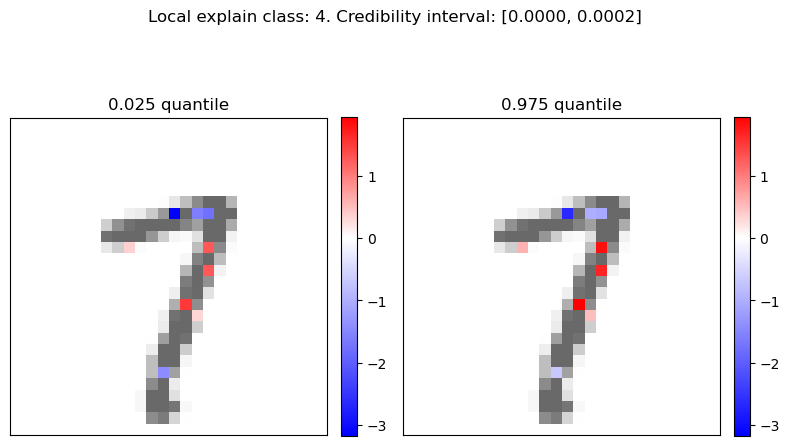

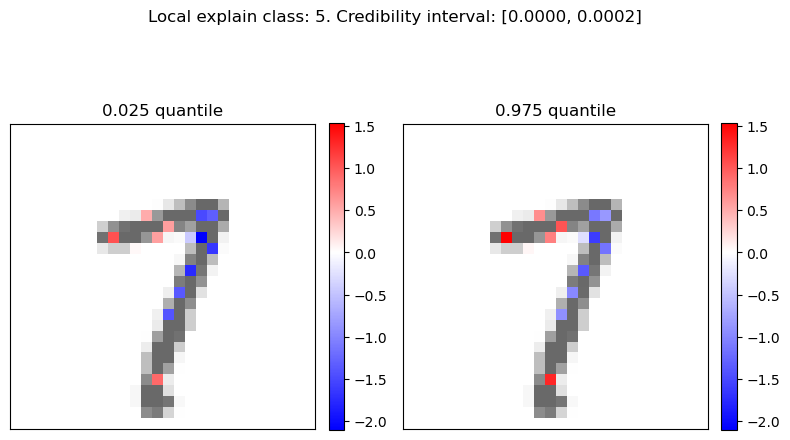

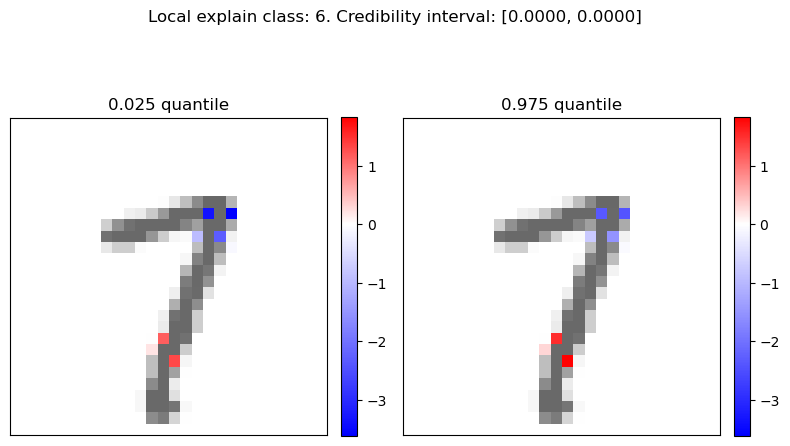

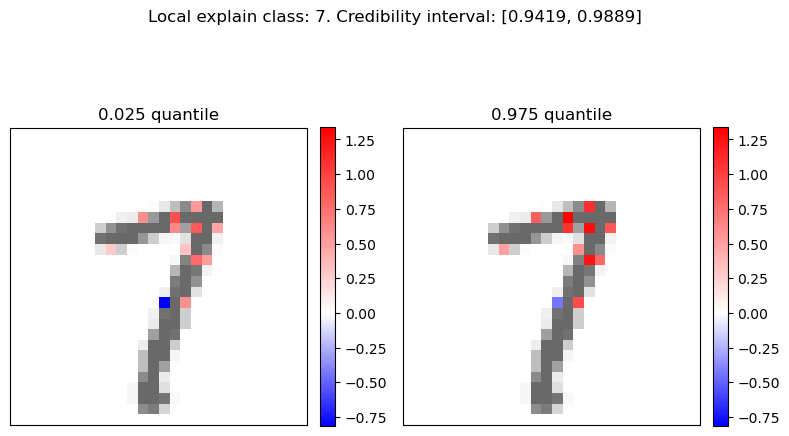

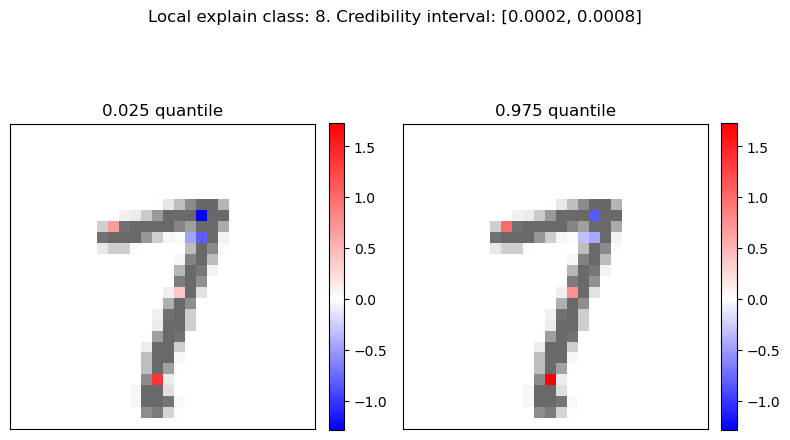

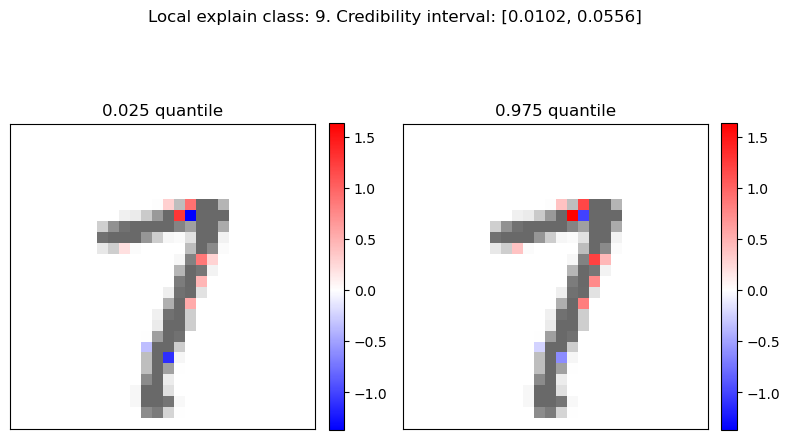

In [15]:
pf.plot_local_contribution_images_contribution_empirical(net, explain_this, n_classes=n_classes, n_samples=100, save_path="local_plots/digit7")